<a href="https://www.kaggle.com/code/matthewweisberg/mobilenetv2-transfer-learning-96-5-accuracy?scriptVersionId=111430889" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bird Classifier using Transfer Learning from MobileNetv2

## Notebook Abstract:

This model is a demonstration on using Transfer Learning to build an accurate model quickly.

It will build a model by loading in the dataset and performing image augmentation, running it through the MobileNetV2 model without the top, and using 4 ending dense layers to output a 450 class softmax for each species of bird in the dataset.

The training will be done in 2 rounds of fitting:
* Each round will run for 20 epochs.
* The second round will increase the number of trainable layers at the end of the Mobile Net base model.
* The second round will shrink the learning rate by a scaling factor.

Lets start!

<img src="https://i.pinimg.com/originals/0c/6a/f2/0c6af2ed796422de38d7467cff88bf43.gif" width="400" align="center">

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

## Set Hyperparameters

In [2]:
FILEPATH = '../input/100-bird-species/' # filepath for data
BATCH_SIZE = 256 # keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)


ROUND_1_TRAINABLE_LAYERS = 3 # layers at end of the mobile_net base model to have trainable parameters
ROUND_1_EPOCHS = 20

ROUND_2_TRAINABLE_LAYERS = 74
ROUND_2_LEARNING_SCALER = 0.1
ROUND_2_EPOCHS = 20

LEARNING_RATE = 0.001

MODEL_CHECKPOINT_FILEPATH = './Bird-Classifier-Model-Checkpoint.ckpt' # For loading the best model weights in the event of overfitting.

SEED = 6278 # random seed for repeatability of notebook

## Load Datasets with *image_dataset_from_directory*

In [3]:
# Training Dataset
train = image_dataset_from_directory(directory = FILEPATH + 'train/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Validation Dataset
valid = image_dataset_from_directory(directory = FILEPATH + 'valid/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Test Dataset
test = image_dataset_from_directory(directory = FILEPATH + 'test/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

Found 70626 files belonging to 450 classes.


2022-11-19 04:19:08.925318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 04:19:09.055050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 04:19:09.055842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 04:19:09.058654: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2250 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.


## Visualize Data Samples

2022-11-19 04:19:13.998018: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


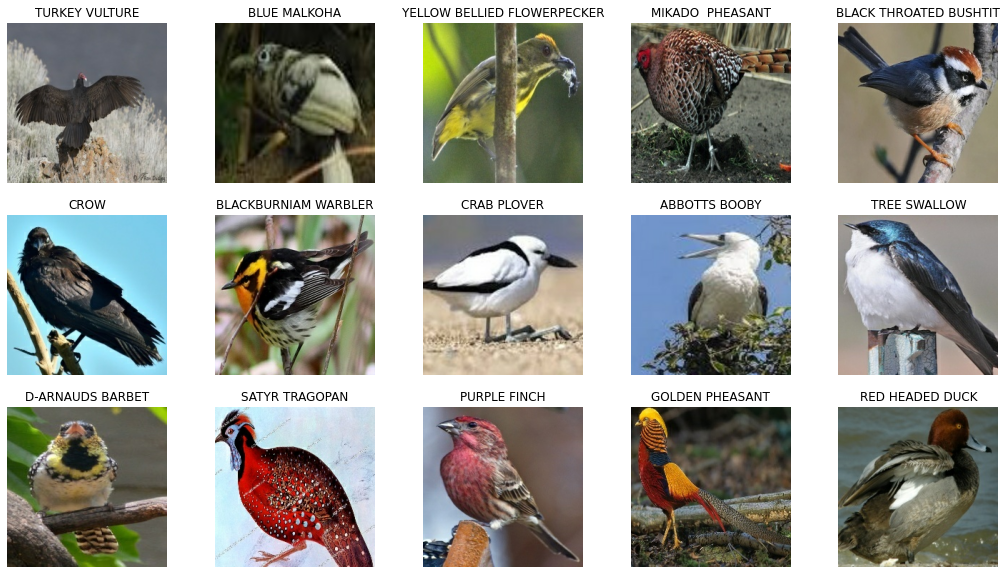

In [4]:
class_names = train.class_names

plt.figure(figsize=(18, 10))

for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Data Augmentation

In [5]:
def data_augmentor(h_flip=True, v_flip=False, rotate=True,):
    
    augmentor = Sequential() # Create returned Sequential class.
    augmentor.add(layers.Rescaling(1./255)) # Rescale image values from 0 - 255 to 0 - 1.

    # Based on function arguments: perform random flipping
    if h_flip and v_flip:
        augmentor.add(layers.RandomFlip('horizontal_and_vertical'))
    elif h_flip:
        augmentor.add(layers.RandomFlip('horizontal'))
    elif v_flip:
        augmentor.add(layers.RandomFlip('vertical'))

    # Based on function arguments: perform random rotation    
    if rotate:
        augmentor.add(layers.RandomRotation(0.2))
    
    return augmentor

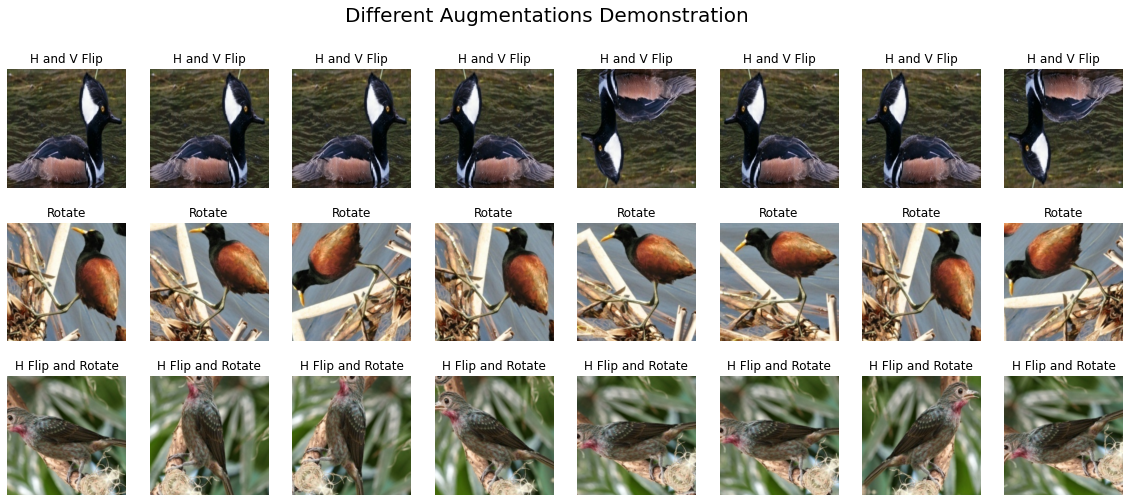

In [6]:
augmentor1 = data_augmentor(h_flip = True, v_flip = True, rotate=False)
augmentor2 = data_augmentor(h_flip = False, v_flip = False, rotate=True)
augmentor3 = data_augmentor(h_flip = True, v_flip = False, rotate=True)

augs = [augmentor1, augmentor2, augmentor3]

details = ['H and V Flip',
           'Rotate',
           'H Flip and Rotate']

plt.figure(figsize=(20, 8))
for images, labels in train.take(1):
    for i, aug in enumerate(augs):
        img = images[i]
        for j in range(8):
            ax = plt.subplot(3, 8, (i*8 + j + 1))
            img_augmented = aug(tf.expand_dims(img, 0))
            plt.imshow(img_augmented[0])
            plt.axis('off')
            ax.set_title(details[i])
            
plt.suptitle('Different Augmentations Demonstration', fontsize=20);

# Import MobileNetV2 Base Model

In [7]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

mobile_base = MobileNetV2(input_shape = IMAGE_SHAPE,
                          include_top = False,
                          weights = 'imagenet')

mn_layers = len(mobile_base.layers)

9420800/9406464 [==============================] - 0s 0us/step


In [8]:
mobile_base.trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!\n'.format(ROUND_1_TRAINABLE_LAYERS))

for mn_layer in mobile_base.layers[:-ROUND_1_TRAINABLE_LAYERS]:
    mn_layer.trainable = False
    
trainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('The number of trainable parameters in the Mobile Net V2 Base Model is {}.'.format(trainableParams))
print('The number of non-trainable parameters in the Mobile Net V2 Base Model is {}.'.format(nonTrainableParams))
print('The total number of parameters is {}.'.format(totalParams))

Setting the last 3 layers in the Mobile Net Base Model to trainable!

The number of trainable parameters in the Mobile Net V2 Base Model is 412160.
The number of non-trainable parameters in the Mobile Net V2 Base Model is 1845824.
The total number of parameters is 2257984.


# Build Model
## Augmentor &rarr; Mobile Net V2 Base &rarr; 4 Dense Layers resulting in Softmax Output

In [9]:
# start model with input shape equal to image shape
inputs = tf.keras.Input(shape = IMAGE_SHAPE)
# apply h-flip and rotation data augmentation
x = augmentor3(inputs)
# apply through mobile net v2 base
x = mobile_base(x)
# global average pool to collapse to 1D
x = layers.GlobalAveragePooling2D()(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.25 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected layer with 2000
x = layers.Dense(1500)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.25 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(1200)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.25 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(900)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.25 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
outputs = layers.Dense(450, activation='softmax')(x) 
        
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
re_lu (ReLU)                 (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

# Train Model

In [10]:
optimizer_1 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

model.compile(optimizer = optimizer_1,
              loss = loss,
              metrics=['accuracy'])

In [11]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_1_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/20


2022-11-19 04:19:36.829483: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


276/276 [==============================] - 270s 934ms/step - loss: 2.8209 - accuracy: 0.3962 - val_loss: 1.0206 - val_accuracy: 0.7067

Epoch 00001: val_accuracy improved from -inf to 0.70667, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 2/20
276/276 [==============================] - 111s 393ms/step - loss: 1.4487 - accuracy: 0.6238 - val_loss: 0.6771 - val_accuracy: 0.8027

Epoch 00002: val_accuracy improved from 0.70667 to 0.80267, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 3/20
276/276 [==============================] - 143s 510ms/step - loss: 1.1988 - accuracy: 0.6783 - val_loss: 0.5665 - val_accuracy: 0.8333

Epoch 00003: val_accuracy improved from 0.80267 to 0.83333, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 4/20
276/276 [==============================] - 116s 414ms/step - loss: 1.0626 - accuracy: 0.7096 - val_loss: 0.4876 - val_accuracy: 0.8480

Epoch 00004: val_accuracy improved from 0.83333 to 0.84800, saving model to ./

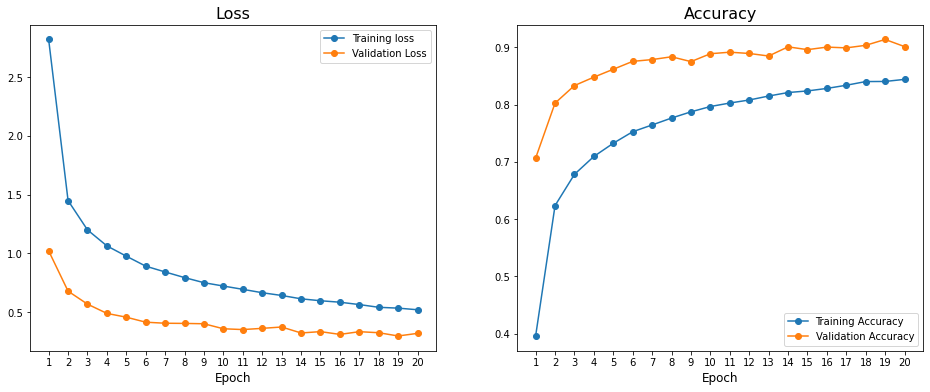

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = ROUND_1_EPOCHS

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [13]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_2_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_2_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 74 layers in the Mobile Net Base Model to trainable!


In [14]:
optimizer_2 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER)

callbacks = [model_checkpoint, model.history]

model.compile(optimizer = optimizer_2,
              loss = loss,
              metrics=['accuracy'])

In [15]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_2_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/20
276/276 [==============================] - 145s 498ms/step - loss: 0.4999 - accuracy: 0.8538 - val_loss: 0.6348 - val_accuracy: 0.8196

Epoch 00001: val_accuracy did not improve from 0.91378
Epoch 2/20
276/276 [==============================] - 139s 494ms/step - loss: 0.3195 - accuracy: 0.9022 - val_loss: 0.4619 - val_accuracy: 0.8609

Epoch 00002: val_accuracy did not improve from 0.91378
Epoch 3/20
276/276 [==============================] - 150s 532ms/step - loss: 0.2610 - accuracy: 0.9204 - val_loss: 0.3420 - val_accuracy: 0.8951

Epoch 00003: val_accuracy did not improve from 0.91378
Epoch 4/20
276/276 [==============================] - 142s 507ms/step - loss: 0.2326 - accuracy: 0.9290 - val_loss: 0.3069 - val_accuracy: 0.9080

Epoch 00004: val_accuracy did not improve from 0.91378
Epoch 5/20
276/276 [==============================] - 157s 558ms/step - loss: 0.2087 - accuracy: 0.9342 - val_loss: 0.2500 - val_accuracy: 0.9276

Epoch 00005: val_accuracy improved from 0.913

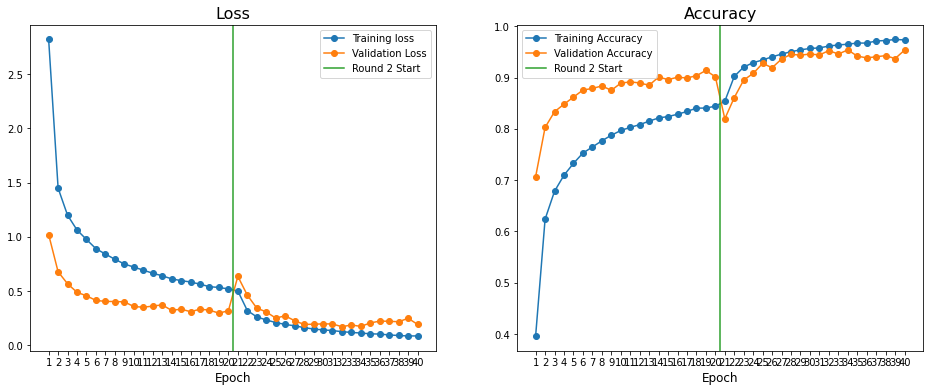

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs += ROUND_2_EPOCHS
new_rounds = [ROUND_1_EPOCHS + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize)

for new_round in new_rounds:
    ax1.axvline(new_round, c='tab:green', label = 'Round 2 Start')
    ax2.axvline(new_round, c='tab:green', label = 'Round 2 Start')

ax1.legend()
ax2.legend();

# Evaluate Model Accuracy on Test Data

In [17]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH)

test_loss, test_accuracy = model.evaluate(test)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

2022-11-19 06:00:02.033860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1741 of 2048
2022-11-19 06:00:03.504000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


9/9 [==============================] - 15s 306ms/step - loss: 0.1288 - accuracy: 0.9600

The model had an accuracy score of 96.0%!!


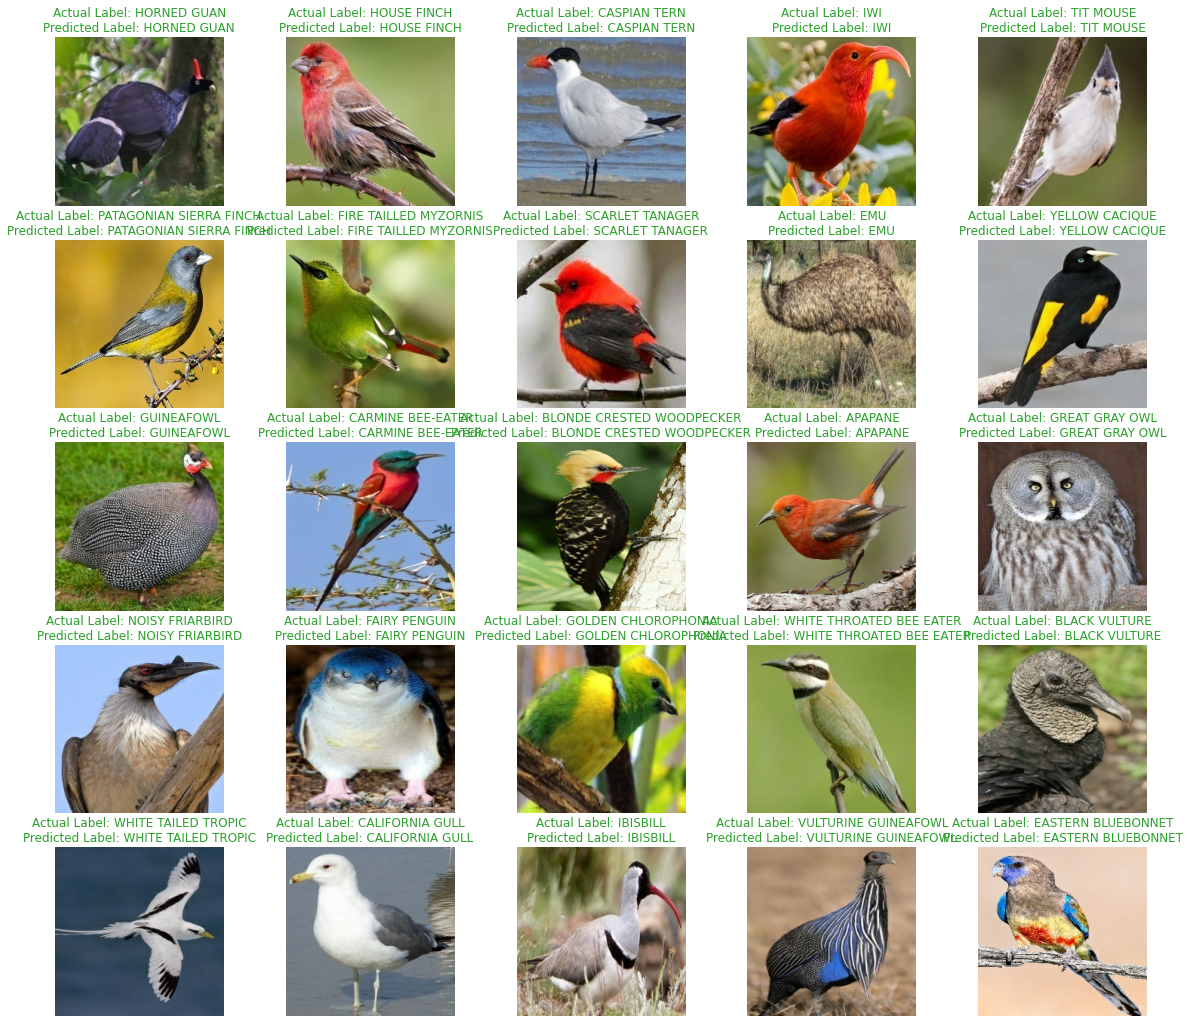

In [18]:
plt.figure(figsize=(20, 18))

for images, labels in test.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")